In [10]:
import torch
from torch import nn
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision import transforms as T


def read_images_from(path):
    # generator instead of list
    images = (cv2.imread(os.path.join(path, fn)) for fn in os.listdir(path))
    return images


def initial_transforms(image):
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = torch.FloatTensor(image / 255).unsqueeze(0)
    image = T.Normalize(mean=0.5, std=0.5)(image)
    return image


def to_tensor_stack(images):
    images = torch.stack(list(map(initial_transforms, images)))
    return images


normal_images_train = to_tensor_stack(read_images_from('./dataset/train'))
abnormal_images = to_tensor_stack(read_images_from('./dataset/proliv'))
images_test = to_tensor_stack(read_images_from('./dataset/test/imgs'))

In [11]:
from torchinfo import summary
epochs = 1000
batch_size = 512
noise_dim = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device')

using cuda device


In [12]:
class DiscriminatorNet(nn.Module):
    def __init__(self, scale_factor):
        super(DiscriminatorNet, self).__init__()

        self.main = nn.Sequential(nn.Conv2d(1, int(8*scale_factor), 2, padding=1, stride=2, bias=False),
                                  nn.BatchNorm2d(int(8*scale_factor)),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Conv2d(
                                      int(8*scale_factor), int(32*scale_factor), 2, padding=1, stride=4, bias=False),
                                  nn.BatchNorm2d(int(32*scale_factor)),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Conv2d(
                                      int(32*scale_factor), int(64*scale_factor), 2, padding=1, stride=3, bias=False),
                                  nn.BatchNorm2d(int(64*scale_factor)),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Conv2d(int(64*scale_factor),
                                            1, 4, bias=False),
                                  nn.Sigmoid())

    def forward(self, x):
        return self.main(x)

In [13]:
discriminator = DiscriminatorNet(scale_factor=2)
summary(discriminator, input_size=(batch_size, 1, 64, 64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
DiscriminatorNet                         [512, 1, 1, 1]            --
├─Sequential: 1-1                        [512, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [512, 16, 33, 33]         64
│    └─BatchNorm2d: 2-2                  [512, 16, 33, 33]         32
│    └─LeakyReLU: 2-3                    [512, 16, 33, 33]         --
│    └─Conv2d: 2-4                       [512, 64, 9, 9]           4,096
│    └─BatchNorm2d: 2-5                  [512, 64, 9, 9]           128
│    └─LeakyReLU: 2-6                    [512, 64, 9, 9]           --
│    └─Conv2d: 2-7                       [512, 128, 4, 4]          32,768
│    └─BatchNorm2d: 2-8                  [512, 128, 4, 4]          256
│    └─LeakyReLU: 2-9                    [512, 128, 4, 4]          --
│    └─Conv2d: 2-10                      [512, 1, 1, 1]            2,048
│    └─Sigmoid: 2-11                     [512, 1, 1, 1]            --
Tot

In [14]:
class GeneratorNet(nn.Module):
    def __init__(self, scale_factor, noise_dim):
        super(GeneratorNet, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, scale_factor *
                               64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(scale_factor * 64),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 64,
                               scale_factor * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(scale_factor * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 32,
                               scale_factor * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(scale_factor * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 16,
                               scale_factor * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(scale_factor * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(scale_factor * 8, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.main(z)

        return x

In [15]:
generator = GeneratorNet(scale_factor=2, noise_dim=noise_dim)
summary(generator, input_size=(batch_size, noise_dim, 1, 1), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
GeneratorNet                             [512, 1, 64, 64]          --
├─Sequential: 1-1                        [512, 1, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [512, 128, 4, 4]          262,144
│    └─BatchNorm2d: 2-2                  [512, 128, 4, 4]          256
│    └─ReLU: 2-3                         [512, 128, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [512, 64, 8, 8]           131,072
│    └─BatchNorm2d: 2-5                  [512, 64, 8, 8]           128
│    └─ReLU: 2-6                         [512, 64, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [512, 32, 16, 16]         32,768
│    └─BatchNorm2d: 2-8                  [512, 32, 16, 16]         64
│    └─ReLU: 2-9                         [512, 32, 16, 16]         --
│    └─ConvTranspose2d: 2-10             [512, 16, 32, 32]         8,192
│    └─BatchNorm2d: 2-11                 [512, 16, 32, 32]        

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


generator.apply(weights_init)
discriminator.apply(weights_init)

DiscriminatorNet(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 64, kernel_size=(2, 2), stride=(4, 4), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(3, 3), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)

In [17]:
from torch.utils.data import TensorDataset, DataLoader


train_dataset = TensorDataset(normal_images_train)
abnormal_images_dataset = TensorDataset(abnormal_images)


train_loader = DataLoader(train_dataset, batch_size=batch_size)
# хочу по ходу обучения отследить динамику ошибки для нормальных и аномальных изображений
abnormal_images_loader = DataLoader(
    abnormal_images_dataset, batch_size=batch_size)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [18]:
from tqdm.notebook import trange

generator_loss_train = list()
discriminator_loss_train = list()

generator = generator.to(device)
discriminator = discriminator.to(device)

for epoch in trange(epochs):
    discriminator.train()
    generator.train()

    generator_loss = 0
    discriminator_loss = 0

    for (real_img,) in train_loader:
        optimizerD.zero_grad()

        real_img = real_img.to(device)

        real_labels = torch.ones(
            (real_img.shape[0],), device=device, dtype=torch.float) * 0.9
        fake_labels = torch.zeros(
            (real_img.shape[0],), device=device, dtype=torch.float)

        real_pred = discriminator(real_img).squeeze(dim=(1, 2, 3))
        lossD_real = criterion(real_pred, real_labels)
        lossD_real.backward()

        z = torch.randn(real_img.shape[0], noise_dim, 1, 1).to(device)
        fake_img = generator(z)

        fake_pred = discriminator(fake_img.detach()).squeeze(dim=(1, 2, 3))
        lossD_fake = criterion(fake_pred, fake_labels)
        lossD_fake.backward()

        optimizerD.step()
        optimizerG.zero_grad()

        fake_pred = discriminator(fake_img).squeeze(dim=(1, 2, 3))
        lossG = criterion(fake_pred, real_labels)
        lossG.backward()

        optimizerG.step()

        generator_loss += lossG.item()
        discriminator_loss += lossD_fake.item() + lossD_real.item()

    if epoch % 20 == 0:
        print(f'Epoch: {epoch}/{epochs}, Generator loss: {round(generator_loss, 6)}, discriminator loss: {round(discriminator_loss, 6)}')

    generator_loss_train.append(generator_loss)
    discriminator_loss_train.append(discriminator_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0/1000, Generator loss: 15.079354, discriminator loss: 40.305111
Epoch: 20/1000, Generator loss: 26.767951, discriminator loss: 24.435012
Epoch: 40/1000, Generator loss: 18.655744, discriminator loss: 30.009755
Epoch: 60/1000, Generator loss: 18.594435, discriminator loss: 28.330254
Epoch: 80/1000, Generator loss: 16.802334, discriminator loss: 28.049692
Epoch: 100/1000, Generator loss: 18.166151, discriminator loss: 26.464573
Epoch: 120/1000, Generator loss: 16.509576, discriminator loss: 27.992137
Epoch: 140/1000, Generator loss: 16.193092, discriminator loss: 28.199668
Epoch: 160/1000, Generator loss: 16.161978, discriminator loss: 28.107621
Epoch: 180/1000, Generator loss: 16.801007, discriminator loss: 27.440419
Epoch: 200/1000, Generator loss: 16.82778, discriminator loss: 27.485954
Epoch: 220/1000, Generator loss: 16.392759, discriminator loss: 27.648579
Epoch: 240/1000, Generator loss: 16.535633, discriminator loss: 27.44469
Epoch: 260/1000, Generator loss: 16.298589, di

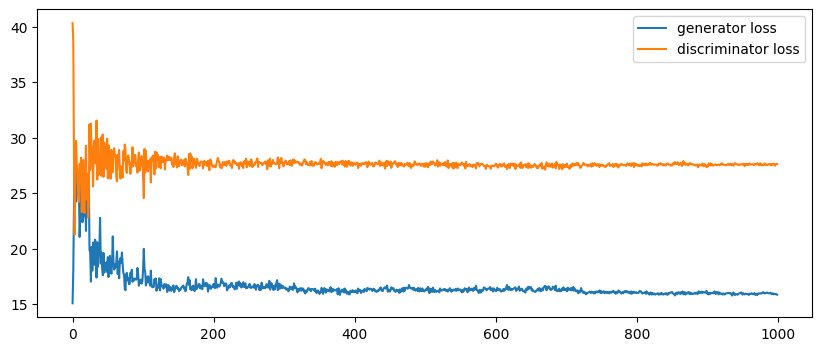

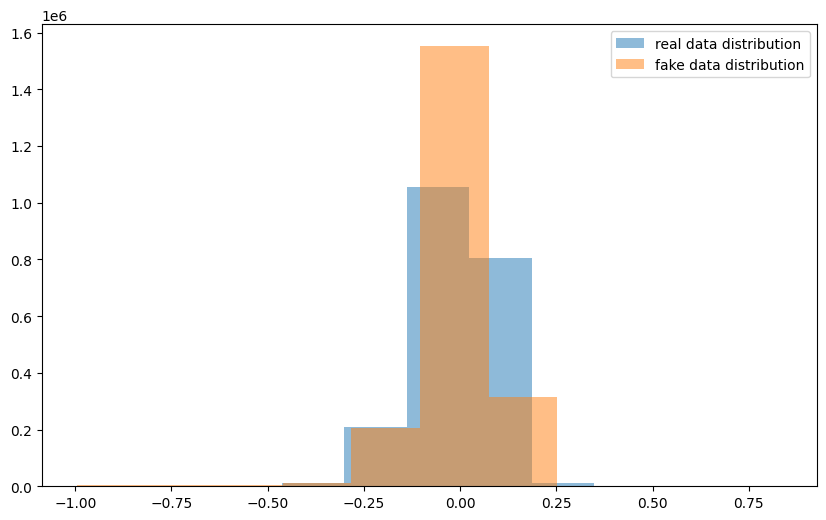

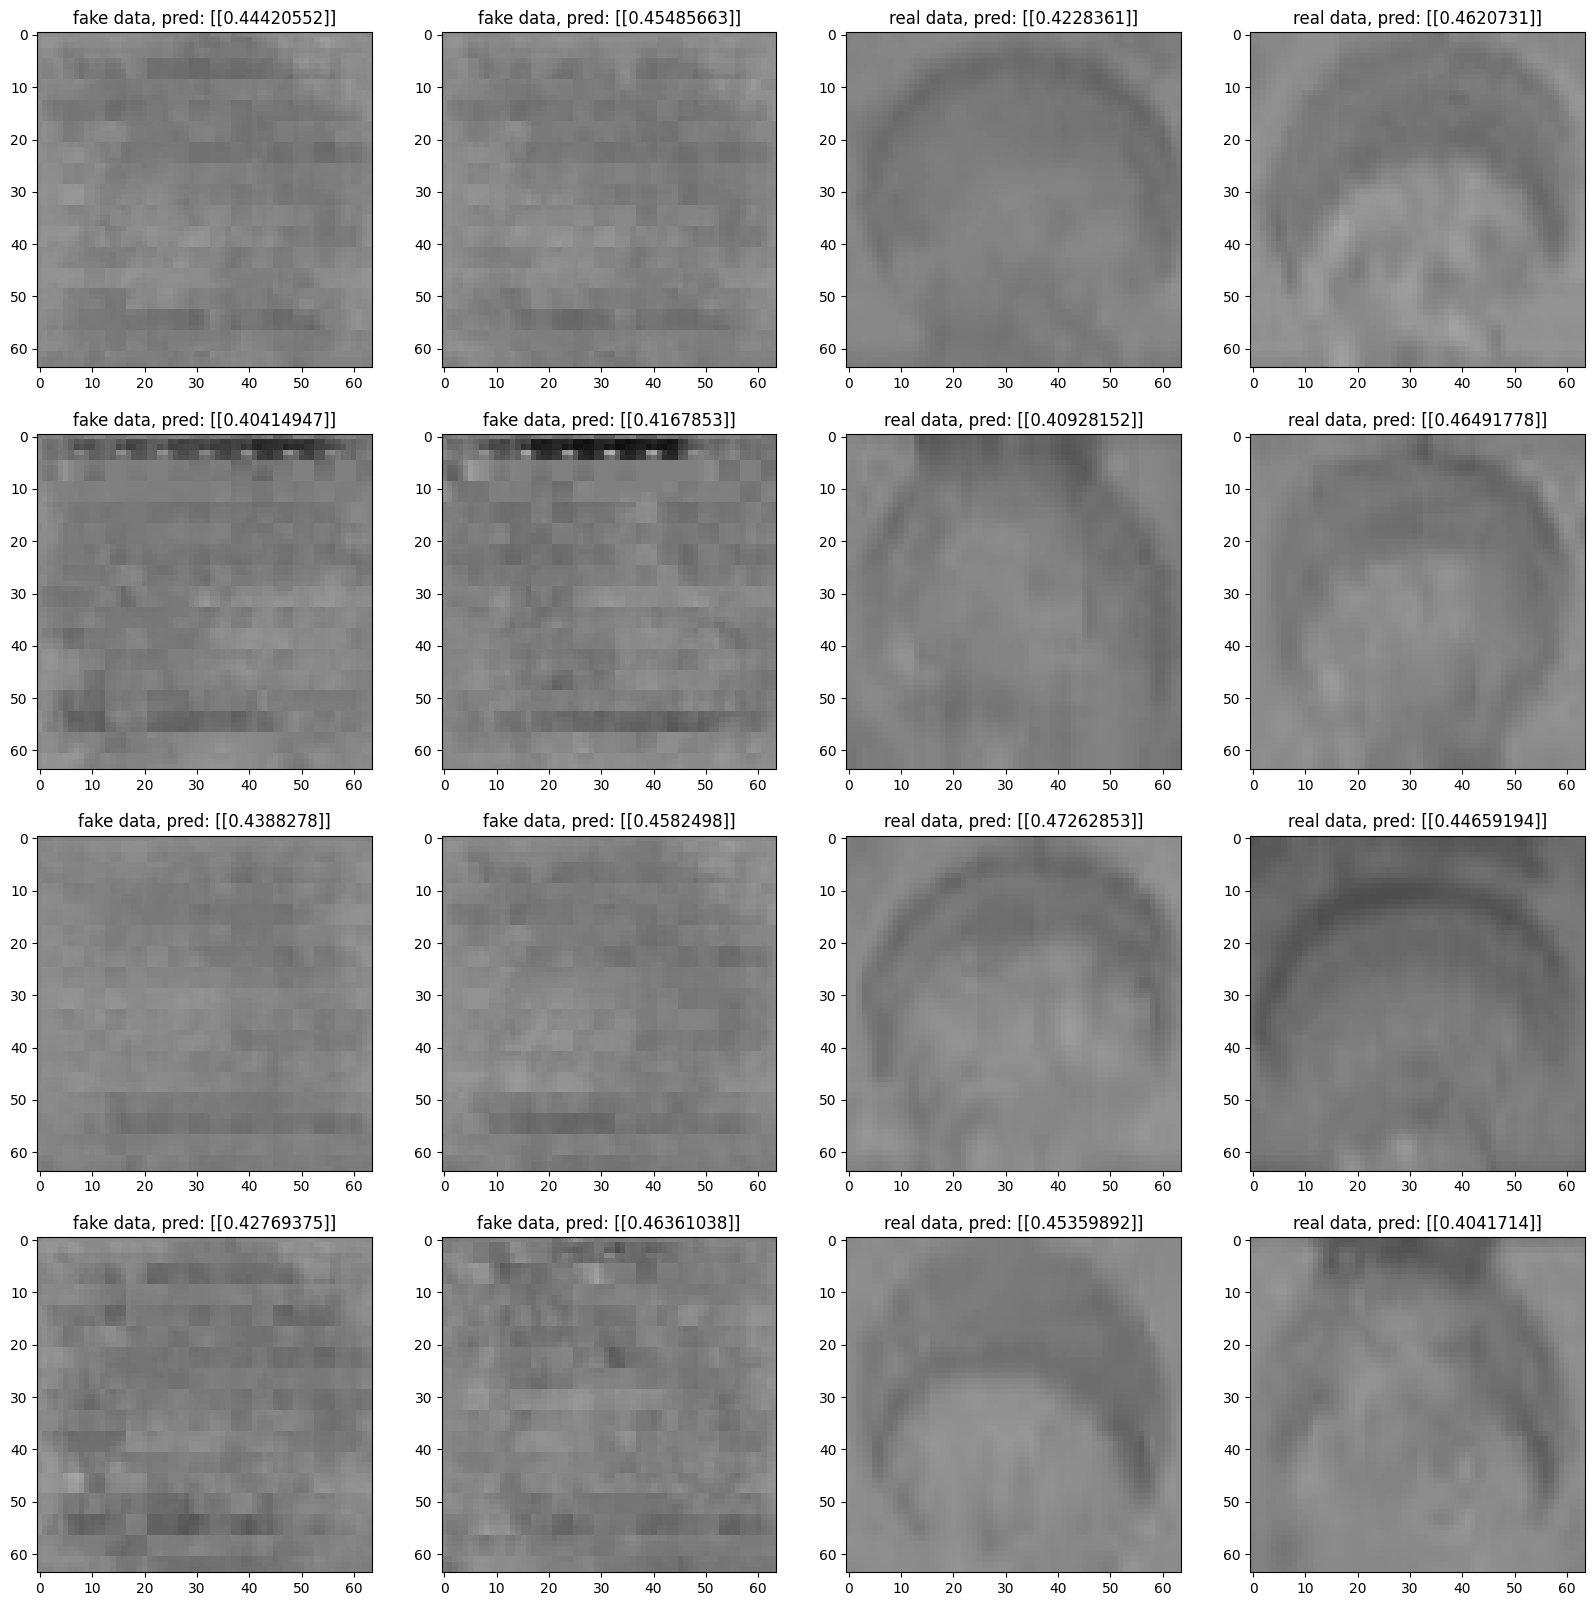

In [19]:
import matplotlib.pyplot as plt

z = torch.randn(batch_size, noise_dim, 1, 1).to(device)
fake_imgs = generator(z)
fake_imgs_preds = discriminator(fake_imgs.detach()).detach().cpu().numpy()
fake_imgs = fake_imgs.detach().cpu()

real_imgs = next(iter(train_loader))[0]
real_imgs_preds = discriminator(real_imgs.to(device)).detach().cpu().numpy()

fig = plt.figure(figsize=(10, 4))
plt.plot(generator_loss_train, label='generator loss')
plt.plot(discriminator_loss_train, label='discriminator loss')
plt.legend()

fig = plt.figure(figsize=(10, 6))
plt.hist(normal_images_train[:batch_size].view(-1),
         label='real data distribution', alpha=0.5)
plt.hist(fake_imgs.view(-1), label='fake data distribution', alpha=0.5)
plt.legend()

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

for i in range(8):
    axes[i // 2, i % 2].imshow(fake_imgs[i][0].numpy(),
                               cmap='gray', vmin=-1, vmax=1)
    axes[i // 2, i % 2].set_title(f'fake data, pred: {fake_imgs_preds[i][0]}')

for i in range(8):
    axes[i // 2, 2 + i %
         2].imshow(real_imgs[i][0].numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[i // 2, 2 + i %
         2].set_title(f'real data, pred: {real_imgs_preds[i][0]}')

In [22]:
images_test = {fn: cv2.imread(os.path.join('./dataset/test/imgs', fn))
               for fn in os.listdir('./dataset/test/imgs')}

with open('./dataset/test/test_annotation.txt') as f:
    lines = f.readlines()

    lines = [x.strip().split() for x in lines]


    markup = {x[0]: int(x[1]) for x in lines}


images_test = list(
    dict(sorted(images_test.items(), key=lambda x: x[0])).values())

images_test = torch.stack(list(map(initial_transforms, images_test)))

images_test = T.Normalize(mean=0.5, std=0.5)(images_test)


markup = np.array(
    list(dict(sorted(markup.items(), key=lambda x: x[0])).values()))


images_test.shape

torch.Size([3794, 1, 64, 64])

test data estimated threshold: 0.171717 with TPR=0.426 TNR=0.531


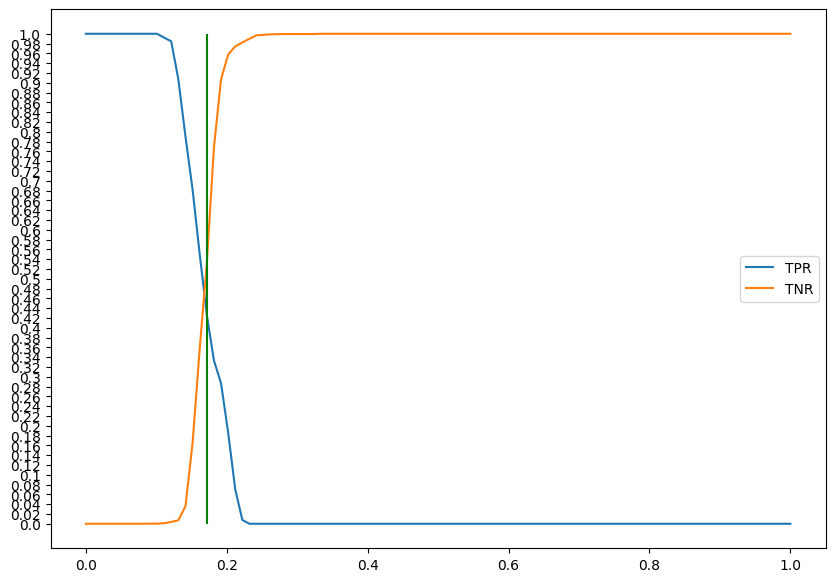

In [23]:
y_pred = discriminator(images_test.to(device)).detach().cpu().view(-1).numpy()


def calculate_metrics(y_pred, labels, thr):
    y_pred[y_pred < thr] = 0
    y_pred[y_pred > 0] = 1

    TP = ((y_pred + labels) == 2).sum()
    TN = ((y_pred + labels) == 0).sum()

    TPR = TP / (labels == 1).sum()
    TNR = TN / (labels == 0).sum()

    return TPR, TNR


TPRs = list()
TNRs = list()

linspace_params = (0, 1, 100)

for thr in np.linspace(*linspace_params):
    TPR, TNR = calculate_metrics(y_pred.copy(), markup, thr)

    TPRs.append(TPR)
    TNRs.append(TNR)

plt.figure(figsize=(10, 7))

plt.plot(np.linspace(*linspace_params), TPRs, label='TPR')
plt.plot(np.linspace(*linspace_params), TNRs, label='TNR')

best_thr_test = np.linspace(
    *linspace_params)[np.argmin(np.abs(np.array(TPRs)-np.array(TNRs)))]
plt.vlines([best_thr_test], 0, 1, colors=['green'])

plt.yticks(np.round(np.linspace(0, 1, 51), 2),
           np.round(np.linspace(0, 1, 51), 2))

plt.legend()

TPR, TNR = calculate_metrics(y_pred, np.array(markup), best_thr_test)
print(
    f'test data estimated threshold: {round(best_thr_test, 6)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')